In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import random
import json
import gc

import PIL
from PIL import Image

import numpy as np
import pandas as pd
import torch
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import nibabel as nib
from einops import rearrange
from scipy import ndimage, stats
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
    
from research.data.natural_scenes import NaturalScenesDataset
from research.experiments.nsd.nsd_access import NSDAccess
from research.metrics.metrics import cosine_distance, top_knn_test, r2_score

In [2]:
nsd_path = Path('D:\\Datasets\\NSD\\')
nsd = NaturalScenesDataset(nsd_path, coco_path='X:\\Datasets\\COCO')
stimuli_path = nsd_path / 'nsddata_stimuli' / 'stimuli' / 'nsd' / 'nsd_stimuli.hdf5'
stimulus_images = h5py.File(stimuli_path, 'r')['imgBrick']

In [ ]:
model_names = {
    'clip-vit-large-patch14': ['image_embedding', 'text_embedding'],
    'ViT-B=32': ['embedding'] + [f'transformer.resblocks.{i}' for i in range(12)],
}
encoder_name = 'fracridge'
subjects = [f'subj0{i}' for i in range(1, 9)]

for subject_id, subject_name in enumerate(subjects):
    for model_name, embedding_names in model_names.items():
        for embedding_name in embedding_names:
            
            file_name = '__'.join([subject_name, encoder_name, model_name, embedding_name, 'r2']) + '.nii.gz'
            encoder_path = nsd_path / f'derivatives/encoded_betas/{model_name}/{encoder_name}'
            source_path = encoder_path / file_name
            
            fsavg_data = nsd.to_fs_average_space(subject_id, str(source_path))
            nsd.flat_scatter_plot(fsavg_data['lh'], fsavg_data['rh'], vmax=0.5, vmin=0)
            
            out_path = encoder_path / f'flatmap/{embedding_name}'
            out_path.mkdir(exist_ok=True, parents=True)
            file_name = '__'.join([subject_name, encoder_name, model_name, embedding_name, 'r2']) + '.png'
            print(out_path / file_name)
            plt.savefig(out_path / file_name, bbox_inches='tight', pad_inches=0)
            plt.close()

data array passed
data array passed
D:\Datasets\NSD\derivatives\encoded_betas\clip-vit-large-patch14\fracridge\flatmap\image_embedding\subj01__fracridge__clip-vit-large-patch14__image_embedding__r2.png


In [8]:
model_name = 'clip-vit-large-patch14'
encoder_name = 'fracridge'
subjects = [f'subj0{i}' for i in range(1, 9)]
embeddings = ['image_embedding', 'text_embedding']
encoder = h5py.File(nsd_path / f'derivatives/encoded_betas/{model_name}/{encoder_name}.hdf5', 'r')

In [9]:
# Load encoder data

embedding = 'image_embedding'
num_voxels = None

results = {}
coefs_all = []
indices_all = []
X_all = []
Y_all = []

for i, subject in enumerate(subjects):
    print(subject)
    train_mask, val_mask, test_mask = nsd.get_split(subject, 'split-01')
    
    val_mask = val_mask | test_mask
    
    subject_data = encoder[f'{subject}/{embedding}']
    r2_original = subject_data['r2'][:num_voxels]
    betas_indices = subject_data['volume_indices'][:num_voxels]
    coefs = subject_data['coefs'][:, :num_voxels]
    
    betas_params = dict(
        subject_name=subject,
        betas_indices=betas_indices,
        return_tensor_dataset=False,
        return_volume_indices=True,
    )
    betas, betas_indices_2 = nsd.load_betas(**betas_params)
    Y = betas
    
    '''
    stimulus_params = dict(
        subject_name=subject,
        stimulus_path=f'derivatives/stimulus_embeddings/{model_name}.hdf5',
        stimulus_key=embedding,
        delay_loading=False,
        return_tensor_dataset=False
    )
    stimulus = nsd.load_stimulus(**stimulus_params)
    X = stimulus[val_mask].astype(np.float32)
    num_stimuli = X.shape[0]
    X = X.reshape(num_stimuli, -1)
    '''
    
    #X_all.append(X)
    Y_all.append(Y)
    coefs_all.append(coefs)
    indices_all.append(betas_indices)#_2)

subj01
subj02
subj03
subj04
subj05
subj06
subj07
subj08


In [10]:
# Individual PCA

results = {}
subject_pcas = []

for i, subject in enumerate(subjects):
    results[subject] = []
    pca = PCA()
    subject_pcas.append(pca)
    coefs_transformed = pca.fit_transform(coefs_all[i].T)
    for j in range(100):
        coefs_inv = coefs_transformed[:, j:j+1] @ pca.components_[j:j+1] + pca.mean_
        r2 = r2_score(torch.from_numpy(coefs_all[i].T), torch.from_numpy(coefs_inv), reduction=None, cast_dtype=torch.float64)
        results[subject].append(r2)

In [11]:
# Group PCA

results_all = {}

pca = PCA()
pca.fit(np.concatenate(coefs_all, axis=1).T)

for i, subject in enumerate(subjects):
    print(subject)
    results_all[subject] = []
    coefs_transformed = pca.transform(coefs_all[i].T)
    for j in range(50):
        coefs_inv = coefs_transformed[:, j:j+1] @ pca.components_[j:j+1] + pca.mean_
        r2 = r2_score(torch.from_numpy(coefs_all[i].T), torch.from_numpy(coefs_inv), reduction=None, cast_dtype=torch.float64)
        results_all[subject].append(r2)

subj01
subj02
subj03
subj04
subj05
subj06
subj07
subj08


In [ ]:
# print combined variance explained of C components
C = 100

for subject, result in results_all.items():
    print(subject)
    num_components = 0
    explained_variance = 0.
    for i in range(C):
        explained_variance += result[i].mean()
        #print(i, explained_variance)
    print(explained_variance)

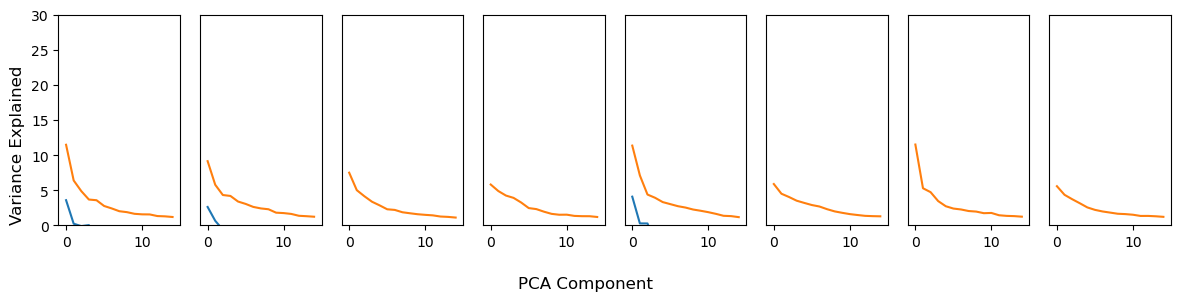

In [27]:
# Plot variance explained of PCA components

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(1.5*len(subjects), 3))
#ax = np.concatenate(ax)
num_components = 15
for i, subject in enumerate(subjects):
    ax[i].plot(
        np.arange(num_components), 
        [r2.mean().item() * 100 for r2 in results_all[subject][:num_components]]
    )
    ax[i].plot(
        np.arange(num_components), 
        [r2.mean().item() * 100 for r2 in results[subject][:num_components]]
    )
    ax[i].set_ylim(0, 30)
    ax[i].set_xlim(-1, num_components)
    if i > 0:
        ax[i].set_yticks([])

fig.supxlabel('PCA Component')
fig.supylabel('Variance Explained')
fig.tight_layout()
out_path = nsd_path / f'derivatives/figures/encoding/{model_name}/{encoder_name}/pca/'
out_path.mkdir(exist_ok=True, parents=True)
file_name = 'variance_explained.png'
plt.savefig(out_path / file_name, bbox_inches='tight', pad_inches=0)
plt.show(fig)

In [14]:
# Load embeddings

stimulus_file = h5py.File(nsd_path / f'derivatives/stimulus_embeddings/{model_name}.hdf5', 'r')
wordnet_file = h5py.File(nsd_path / f"derivatives/word_embeddings/{model_name}.hdf5", "r")

image_embedding = stimulus_file['image_embedding'][:]
text_embedding = stimulus_file['text_embedding'][:]
wordnet_embedding = wordnet_file['embedding'][:]
synsets = wordnet_file['synsets'][:]

#image_neighbors = NearestNeighbors(metric='cosine')
#image_neighbors.fit(image_embedding)

#text_neighbors = NearestNeighbors(metric='cosine')
#text_neighbors.fit(text_embedding)

In [28]:

for subject_id, subject in enumerate(subjects):
    print(subject)
    subject_pca = subject_pcas[subject_id]
    subject_embeddings = subject_pca.transform(image_embedding)

    num_components = 10
    num_images = 10
    images = []
    for component_id in range(num_components):
        component_embeddings = subject_embeddings[:, component_id]
        image_ids = np.argsort(component_embeddings)[::-1][:num_images]
        distances = [component_embeddings[i] for i in image_ids]
        component_images = np.concatenate([stimulus_images[i] for i in image_ids], axis=1)
        images.append(component_images)
        #print(distances)

    images = np.concatenate(images, axis=0)
    out_path = nsd_path / f'derivatives/figures/encoding/{model_name}/{encoder_name}/pca/mscoco_retrieval'
    out_path.mkdir(exist_ok=True, parents=True)
    file_name = '__'.join([subjects[subject_id], 'pca', 'mscoco_retrieval']) + '.png'
    Image.fromarray(images).save(out_path / file_name)
    #plt.figure(figsize=(num_images * 3, num_components * 3))
    #plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    #plt.imshow(images)

subj01
subj02
subj03
subj04
subj05
subj06
subj07
subj08


In [ ]:
coefs_tsne = []
for subject_id in range(8):
    print(subject_id)
    top_n_voxels = None
    tsne = TSNE(
        n_components=2, 
        metric='cosine',
        init="pca", 
        #learning_rate="auto", 
        random_state=2,
        verbose=1,
    )
    coefs_tsne.append(tsne.fit_transform(coefs_all[subject_id].T[:top_n_voxels]))


In [ ]:
top_n_voxels = None
tsne = TSNE(
    n_components=2, 
    metric='cosine',
    init="pca", 
    #learning_rate="auto", 
    random_state=2,
    verbose=1,
)

shuffle_ids = np.arange(coefs_group.shape[0])
np.random.seed(0)
np.random.shuffle(shuffle_ids)
inverse_shuffle_ids = np.argsort(shuffle_ids)

top_n_voxels = None
coefs_group = np.concatenate([coefs_all[subject_id].T[:top_n_voxels] for subject_id in range(8)])
coefs_group = coefs_group[shuffle_ids]
coefs_group_tsne = tsne.fit_transform(coefs_group)
coefs_group_tsne = coefs_group_tsne[inverse_shuffle_ids]

In [ ]:
coefs_group_tsne.shape

In [ ]:
coefs_group_tsne = [
    tensor.numpy() 
    for tensor in torch.split(torch.from_numpy(coefs_group_tsne), [c.T.shape[0] for c in coefs_all])
]

In [ ]:
coefs = coefs_group_tsne
name = 'group_shuffled'

for subject_id in range(8):
    plt.figure(figsize=(24, 24))
    pos_colors = indices_all[subject_id] / np.array(nsd.volume_shape(subject_id))
    plt.scatter(coefs[subject_id][:, 0], coefs[subject_id][:, 1], c=pos_colors)
    out_path = nsd_path / f'derivatives/encoded_betas/{model_name}/{encoder_name}/tsne/{name}/scatter'
    out_path.mkdir(exist_ok=True, parents=True)
    file_name = '__'.join([subjects[subject_id], 'tsne', 'scatterplot', name]) + '.png'
    plt.savefig(out_path / file_name, bbox_inches='tight', pad_inches=0)

    color_coefs = coefs[subject_id] - coefs[subject_id].min(axis=0)
    color_coefs = color_coefs / color_coefs.max(axis=0)
    if color_coefs.shape[1] == 2:
        color_coefs = np.concatenate([color_coefs, np.full_like(color_coefs[..., 0:1], 0.5)], axis=-1)

    volume = np.stack([
        nsd.reconstruct_volume(
            subject_id, 
            torch.from_numpy(coefs_dim), 
            indices_all[subject_id][:coefs_dim.shape[0]],
            0.0
        ).T
        for coefs_dim in list(color_coefs.T)
    ], axis=-1)
    D = volume.shape[2]

    fsavg_data = nsd.to_fs_average_space(subject_id, volume, interp_type='linear')
    nsd.flat_scatter_plot(fsavg_data['lh'], fsavg_data['rh'])
    out_path = nsd_path / f'derivatives/encoded_betas/{model_name}/{encoder_name}/tsne/{name}/flatmap'
    out_path.mkdir(exist_ok=True, parents=True)
    file_name = '__'.join([subjects[subject_id], 'tsne', 'flatmap', name]) + '.png'
    plt.savefig(out_path / file_name, bbox_inches='tight', pad_inches=0)

In [ ]:
plt.figure(figsize=(24, 24))
pos_colors = indices_all[subject_id] / np.array(nsd.volume_shape(subject_id))
plt.scatter(coefs_tsne[:, 0], coefs_tsne[:, 1], c=pos_colors)
out_path = nsd_path / f'derivatives/encoded_betas/{model_name}/{encoder_name}/tsne'
out_path.mkdir(exist_ok=True, parents=True)
file_name = '__'.join([subjects[subject_id], 'tsne', 'scatterplot', 'individual']) + '.png'
plt.savefig(out_path / file_name, bbox_inches='tight', pad_inches=0)

In [ ]:

color_coefs.shape

In [ ]:
subject_id = 0

color_coefs = coefs_tsne[subject_id] - coefs_tsne[subject_id].min(axis=0)
color_coefs = color_coefs / color_coefs.max(axis=0)
if color_coefs.shape[1] == 2:
    color_coefs = np.concatenate([color_coefs, np.full_like(color_coefs[..., 0:1], 0.5)], axis=-1)

volume = np.stack([
    nsd.reconstruct_volume(
        subject_id, 
        torch.from_numpy(coefs_dim), 
        indices_all[subject_id][:coefs_dim.shape[0]],
        0.0
    ).T
    for coefs_dim in list(color_coefs.T)
], axis=-1)
D = volume.shape[2]

@interact(d=(0, D-1))
def show(d):
    plt.figure(figsize=(12, 12))
    plt.imshow(volume[:, :, d])

In [ ]:
from nltk.test.gensim_fixt import setup_module
setup_module()
import gensim

In [30]:
import nltk
from nltk.corpus import wordnet as wn
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Cefir\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


TypeError: len() takes exactly one argument (0 given)

In [ ]:
from transformers import CLIPTokenizer, CLIPModel, CLIPTextModel, CLIPVisionModel, CLIPFeatureExtractor, CLIPProcessor

model_name = "clip-vit-large-patch14"

model = CLIPModel.from_pretrained(f'openai/{model_name}')
#processor = CLIPProcessor.from_pretrained(f'openai/{model_name}')
#processor = CLIPProcessor.from_pretrained(f'openai/{model_name}')
tokenizer = CLIPTokenizer.from_pretrained(f'openai/{model_name}')
#transformer = CLIPTextModel.from_pretrained(f'openai/{model_name}')


In [35]:
from nltk.corpus import brown
nltk.download('brown')
len(brown.words())

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Cefir\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


1161192

In [ ]:
model = model.cuda()

In [33]:
synsets = list(wn.all_synsets())

In [34]:
synset_names = [synset.name().split('.')[0].replace('_', ' ') for synset in synsets]

In [ ]:
len(freqs), (np.array(freqs) > 5).sum()

In [36]:
from nltk.corpus import brown
freqs = nltk.FreqDist([word.lower() for word in brown.words()])
freqs = [freqs[name] for name in synset_names]
_, unique_ids = np.unique(synset_names, return_index=True)
unique_ids = set(unique_ids)
freq_sorted_unique_ids = [
    i for i in np.argsort(freqs)[::-1] 
    if i in unique_ids and len(synset_names[i]) > 2
]
print([synset_names[i] for i in freq_sorted_unique_ids])

['not', 'are', 'have', 'one', 'all', 'there', 'will', 'more', 'out', 'about', 'can', 'only', 'other', 'new', 'some', 'time', 'two', 'may', 'then', 'first', 'any', 'now', 'such', 'like', 'over', 'man', 'even', 'most', 'made', 'after', 'many', 'must', 'through', 'back', 'much', 'way', 'well', 'down', 'each', 'just', 'people', 'little', 'state', 'good', 'very', 'make', 'world', 'still', 'see', 'own', 'work', 'long', 'here', 'get', 'both', 'between', 'life', 'being', 'under', 'never', 'day', 'same', 'another', 'know', 'while', 'last', 'might', 'great', 'old', 'year', 'off', 'come', 'right', 'used', 'take', 'three', 'few', 'use', 'house', 'again', 'place', 'american', 'around', 'however', 'home', 'small', 'found', 'thought', 'say', 'part', 'once', 'general', 'high', 'school', 'every', 'united', 'left', 'number', 'course', 'war', 'always', 'away', 'fact', 'water', 'though', 'public', 'less', 'put', 'think', 'hand', 'enough', 'far', 'head', 'yet', 'government', 'system', 'set', 'better', 'not

In [ ]:
with torch.no_grad():
    ids = np.arange(1000)
    text_embed = model.text_projection(
        model.text_model(**{k: v[ids].cuda() for k, v in tokens.items()}).pooler_output
    )
    text_embed = text_embed / text_embed.norm(p=2, dim=-1, keepdim=True)
    text_embed = text_embed.cpu()

In [ ]:
with torch.no_grad():
    tokens = tokenizer(
        synset_names, return_tensors="pt", padding=True
    )

In [ ]:
with h5py.File(nsd_path / f"derivatives/word_embeddings/{model_name}.hdf5", "a") as f:
    N = len(synsets)
    f.require_dataset('embedding', (N, 768), 'float32')
    f['synsets'] = [synset.name() for synset in synsets]
    for ids in np.array_split(np.arange(N), 100):
        break
        print(ids)
        with torch.no_grad():
            text_embed = model.text_projection(
                model.text_model(**{k: v[ids].cuda() for k, v in tokens.items()}).pooler_output
            )
        text_embed = text_embed / text_embed.norm(p=2, dim=-1, keepdim=True)
        text_embed = text_embed.cpu()
        f['embedding'][ids] = text_embed

In [ ]:
from pycocotools.coco import COCO
coco_path = Path('X:\\Datasets\\COCO')

In [ ]:
clusters

In [38]:
from sklearn.cluster import AgglomerativeClustering, OPTICS, KMeans

clusters = [None] * 8
for subject_id in range(8):
    if subject_id == 5:
        continue
    print(subject_id)
    cluster = AgglomerativeClustering(
        n_clusters=10,
        #distance_threshold=20,
        affinity='euclidean',
        linkage='ward',
        memory=str(nsd_path / 'derivatives/joblib_cache')
    )
    coefs = coefs_all[subject_id].T
    coefs_norm = coefs / np.linalg.norm(coefs, axis=1, keepdims=True)
    cluster.fit(coefs_norm)
    clusters[subject_id] = cluster

0
1
2
3
4
6
7


In [39]:
from sklearn.cluster import AgglomerativeClustering, OPTICS, KMeans
from hdbscan import HDBSCAN
from clip_retrieval.clip_client import ClipClient, Modality
from torchvision import transforms
from urllib.request import urlopen, HTTPError, URLError
from PIL import UnidentifiedImageError

client = ClipClient(
    url="https://knn5.laion.ai/knn-service", 
    indice_name="laion5B",
    aesthetic_score=9,
    aesthetic_weight=0.0,
    use_safety_model=False,
    use_violence_detector=False,
    num_images=5000,
)

name = 'run3'

for subject_id in [0, 1, 2, 3, 4, 6, 7]:
    cluster = clusters[subject_id]
    coefs = coefs_all[subject_id].T
    coefs_norm = coefs / np.linalg.norm(coefs, axis=1, keepdims=True)

    cluster_centroids = np.stack([
        np.median(indices_all[subject_id][cluster.labels_ == i], axis=0) 
        for i in range(cluster.n_clusters_)
    ])

    cluster_ordering = np.argsort(cluster_centroids[:, 1])
    labels = cluster.labels_.copy()
    for i, label in enumerate(cluster_ordering):
        labels[cluster.labels_ == label] = i

    cluster_means = np.stack([
        coefs_norm[labels == i].mean(axis=0) 
        for i in range(cluster.n_clusters_)
    ])
    cluster_means = cluster_means / np.linalg.norm(cluster_means, axis=1, keepdims=True)
    
    num_common_words = 3000
    common_ids = freq_sorted_unique_ids[:num_common_words]
    wordnet_dists = cluster_means @ wordnet_embedding[common_ids].T
    num_words = 10
    print(f'subj0{subject_id+1}')
    for cluster_id in range(cluster.n_clusters_):
        word_ids = np.argsort(wordnet_dists[cluster_id])[::-1][:num_words]
        distances = [wordnet_dists[cluster_id][i] for i in word_ids]
        cluster_words = [synset_names[common_ids[i]] for i in word_ids]
        print(cluster_id, cluster_words)
    continue
    
    Y_cluster_means = np.stack([
        Y_all[subject_id][:, labels == i].mean(axis=1) 
        for i in range(cluster.n_clusters_)
    ])
    responses = nsd.subjects[subjects[subject_id]]['responses']
    response_stimulus_ids = responses['73KID'].to_numpy() - 1

    num_images = 10
    images = []
    for cluster_id in range(cluster.n_clusters_):
        image_ids = np.argsort(Y_cluster_means[cluster_id])[::-1][:num_images]
        image_ids = response_stimulus_ids[image_ids]
        cluster_images = np.concatenate([stimulus_images[i] for i in image_ids], axis=1)
        images.append(cluster_images)

    images = np.concatenate(images, axis=0)
    out_path = nsd_path / f'derivatives/encoded_betas/{model_name}/{encoder_name}/agglomerative/{name}/betas_retrieval'
    out_path.mkdir(exist_ok=True, parents=True)
    file_name = '__'.join([subjects[subject_id], 'agglomerative', 'betas_retrieval', name]) + '.png'
    Image.fromarray(images).save(out_path / file_name)
    
    trans = torch.nn.Sequential(
        transforms.Resize(256),
        transforms.CenterCrop(256),
    )

    num_images = 10
    images = []
    for cluster_id in range(cluster.n_clusters_):
        print(cluster_id)
        response = client.query(embedding_input=cluster_means[cluster_id].tolist())

        cluster_images = []
        for r in response:
            try:
                cluster_images.append(trans(Image.open(urlopen(r['url'], timeout=10))).convert('RGB'))
            except UnidentifiedImageError:
                print("UnidentifiedImageError")
            except HTTPError:
                print("HTTPError")
            except URLError:
                print("URLError")
            except ConnectionResetError:
                print("ConnectionResetError")
            except:
                print("timeout?")

            if len(cluster_images) >= num_images:
                break

        cluster_images = np.concatenate(cluster_images, axis=1)
        images.append(cluster_images)
    images = np.concatenate(images, axis=0)
    
    out_path = nsd_path / f'derivatives/encoded_betas/{model_name}/{encoder_name}/agglomerative/{name}/clip_retrieval'
    out_path.mkdir(exist_ok=True, parents=True)
    file_name = '__'.join([subjects[subject_id], 'agglomerative', 'clip_retreival', name]) + '.png'
    Image.fromarray(images).save(out_path / file_name)
    
    image_dists = cluster_means @ image_embedding.T
    num_images = 10
    images = []
    for cluster_id in range(cluster.n_clusters_):
        image_ids = np.argsort(image_dists[cluster_id])[::-1][:num_images]
        distances = [image_dists[cluster_id][i] for i in image_ids]
        cluster_images = np.concatenate([stimulus_images[i] for i in image_ids], axis=1)
        images.append(cluster_images)
        #print(distances)

    images = np.concatenate(images, axis=0)

    out_path = nsd_path / f'derivatives/encoded_betas/{model_name}/{encoder_name}/agglomerative/{name}/mscoco_retrieval'
    out_path.mkdir(exist_ok=True, parents=True)
    file_name = '__'.join([subjects[subject_id], 'agglomerative', 'mscoco_retrieval', name]) + '.png'
    Image.fromarray(images).save(out_path / file_name)
    
    volume = nsd.reconstruct_volume(
        subject_id, 
        torch.from_numpy(labels).float(), 
        indices_all[subject_id][:cluster.labels_.shape[0]],
        -1
    ).T.numpy()
    D = volume.shape[2]

    fsavg_data = nsd.to_fs_average_space(subject_id, volume, interp_type='nearest')
    nsd.flat_scatter_plot(fsavg_data['lh'], fsavg_data['rh'], vmax=cluster.n_clusters_ - 1, vmin=-1, mask_value=-1)
    out_path = nsd_path / f'derivatives/encoded_betas/{model_name}/{encoder_name}/agglomerative/{name}/flatmap'
    out_path.mkdir(exist_ok=True, parents=True)
    file_name = '__'.join([subjects[subject_id], 'agglomerative', 'flatmap', name]) + '.png'
    plt.savefig(out_path / file_name, bbox_inches='tight', pad_inches=0)

    #plt.figure(figsize=(24, 24))
    #plt.scatter(coefs_tsne[subject_id][:, 0], coefs_tsne[subject_id][:, 1], c=labels, cmap='jet')

subj01
0 ['detailed', 'morgan', 'capacity', 'elaborate', 'vigorous', 'legs', 'pattern', 'forest', 'precious', 'wages']
1 ['hot', 'vigorous', 'intelligence', 'thick', 'precious', 'detailed', 'beauty', 'pretty', 'depression', 'love']
2 ['leg', 'flexible', 'arm', 'war', 'connection', 'fit', 'gun', 'jet', 'devil', 'combat']
3 ['split', 'path', 'reputation', 'guess', 'magnitude', 'belt', 'set', 'stations', 'maintenance', 'pattern']
4 ['mirror', 'connection', 'tangent', 'split', 'maintenance', 'leg', 'valley', 'concrete', 'suburban', 'illusion']
5 ['interior', 'suburban', 'valley', 'stairs', 'basement', 'mud', 'mirror', 'eleven', 'parked', 'path']
6 ['dictionary', 'define', 'kid', 'criminal', 'terror', 'accuracy', 'america', 'stranger', 'player', 'boy']
7 ['saw', 'mathematical', 'zero', 'tangent', 'maintenance', 'split', 'bad', 'accuracy', 'tape', 'logical']
8 ['aim', 'connection', 'mirror', 'arm', 'leg', 'municipal', 'flexible', 'maintenance', 'rifle', 'dispute']
9 ['innocence', 'kid', 'dic

In [ ]:
for subject_id in [0]:
    cluster = AgglomerativeClustering(
        n_clusters=10,
        #distance_threshold=20,
        affinity='euclidean',
        linkage='ward',
        memory=str(nsd_path / 'derivatives/joblib_cache')
    )
    coefs = coefs_all[subject_id].T
    coefs_norm = coefs / np.linalg.norm(coefs, axis=1, keepdims=True)
    cluster.fit(coefs_norm)
    print(cluster.n_clusters_)

    cluster_centroids = np.stack([
        np.median(indices_all[subject_id][cluster.labels_ == i], axis=0) 
        for i in range(cluster.n_clusters_)
    ])

    cluster_ordering = np.argsort(cluster_centroids[:, 1])
    labels = cluster.labels_.copy()
    for i, label in enumerate(cluster_ordering):
        labels[cluster.labels_ == label] = i

    responses = nsd.subjects[subjects[subject_id]]['responses']
    response_stimulus_ids = responses['73KID'].to_numpy() - 1

In [ ]:
Y_all[subject_id][:, labels == 0].mean(axis=1).shape

In [ ]:
labels.shape

In [ ]:
Y_all[1].shape

In [ ]:
response_stimulus_ids.shape

In [ ]:
Y_all[subject_id].shape

In [ ]:
cluster_means = np.stack([
        coefs_norm[labels == i].mean(axis=0) 
        for i in range(cluster.n_clusters_)
    ])
    cluster_means = cluster_means / np.linalg.norm(cluster_means, axis=1, keepdims=True)

In [ ]:
np.unique(labels)

In [ ]:

#client.query(embedding_input=cluster_means[0].tolist())

In [ ]:
from urllib.request import urlopen, HTTPError

In [ ]:
trans = torch.nn.Sequential(
    transforms.Resize(256),
    transforms.CenterCrop(256),
)

num_images = 5
images = []
for cluster_id in range(cluster.n_clusters_):
    print(cluster_id)
    response = client.query(embedding_input=cluster_means[cluster_id].tolist())
    
    cluster_images = []
    for r in response:
        try:
            cluster_images.append(trans(Image.open(urlopen(r['url']))).convert('RGB'))
        except UnidentifiedImageError:
            pass
        except HTTPError:
            pass
        except URLError:
            pass
        
        if len(cluster_images) >= num_images:
            break
        
    cluster_images = np.concatenate(cluster_images, axis=1)
    images.append(cluster_images)
images = np.concatenate(images, axis=0)

plt.figure(figsize=(num_images * 3, cluster.n_clusters_ * 3))
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.imshow(images)

In [ ]:
plt.figure(figsize=(num_images * 3, cluster.n_clusters_ * 3))
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.imshow(images)

In [ ]:
image_dists = cluster_means @ image_embedding.T

num_images = 10
images = []
for cluster_id in range(image_dists.shape[0]):
    image_ids = np.argsort(image_dists[cluster_id])[::-1][:num_images]
    distances = [image_dists[cluster_id][i] for i in image_ids]
    cluster_images = np.concatenate([stimulus_images[i] for i in image_ids], axis=1)
    images.append(cluster_images)
    #print(distances)
    
images = np.concatenate(images, axis=0)

plt.figure(figsize=(num_images * 3, image_dists.shape[0] * 3))
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.imshow(images)

In [ ]:
volume = nsd.reconstruct_volume(
    subject_id, 
    torch.from_numpy(labels).float(), 
    indices_all[subject_id][:cluster.labels_.shape[0]],
    np.nan
).T
D = volume.shape[2]

@interact(d=(0, D-1))
def show(d):
    plt.figure(figsize=(12, 12))
    plt.imshow(volume[:, :, d], cmap='jet', vmin=-3)

In [ ]:
volume = nsd.reconstruct_volume(
    subject_id, 
    torch.from_numpy(labels).float(), 
    indices_all[subject_id][:cluster.labels_.shape[0]],
    -1
).T.numpy()
D = volume.shape[2]

fsavg_data = nsd.to_fs_average_space(subject_id, volume, interp_type='nearest')
nsd.flat_scatter_plot(fsavg_data['lh'], fsavg_data['rh'], vmax=cluster.n_clusters_ - 1, vmin=-1, mask_value=-1)

In [ ]:
cluster.labels_.shape[1]

In [ ]:
np.unique(volume)

In [ ]:
volume.max()

In [ ]:
coefs = coefs_all[0].T
coefs_norm = coefs / np.linalg.norm(coefs, axis=1, keepdims=True)
distances = coefs_norm @ coefs_norm.T
plt.imshow(distances)

In [ ]:
plt.hist(distances[np.triu_indices(distances.shape[0], k=1)])

In [ ]:
coefs.shape